# Visual Analysis of model evaluation

## Imports

In [75]:
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn.functional as F
from PIL import Image

from src.const.maps import EMOTION_MAP, IDX_TO_EMOTION
from src.const.paths import MODELS_DIR
from src.const.transforms import VAL_TRANSFORM
from src.models.trainer import EmotionClassifier

In [76]:
CKPT_FROZEN = MODELS_DIR / "mobilenet_v3_kdef-frozen-epoch=10-val_f1=0.64.ckpt"
CKPT_UNFROZEN = MODELS_DIR / "mobilenet_v3_kdef-unfrozen-epoch=13-val_f1=0.92.ckpt"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [78]:
res_df = pd.read_csv("outputs/evaluation_results.csv")

model_unfrozen = EmotionClassifier.load_from_checkpoint(CKPT_UNFROZEN).to("cuda")

## Visualisation

In [79]:
def visualize_failures(
    df,
    model1_col,
    model2_col,
    domain="Degraded",
    count=8,
    base_path="data/degraded",
    model_names=None,
):
    names_map = {
        "pred_unfrozen": "MNv3 Unfrozen",
        "pred_frozen": "MNv3 Frozen",
        "pred_deepface": "DeepFace",
    }
    if model_names:
        names_map.update(model_names)

    model1_name = names_map.get(model1_col, model1_col)
    model2_name = names_map.get(model2_col, model2_col)

    subset = df[
        (df["domain"] == domain)
        & (df[model1_col] == df["true_idx"])
        & (df[model2_col] != df["true_idx"])
        & (df[model2_col] != -1)
    ]

    if subset.empty:
        print(
            f"No samples found where {model1_name} is correct and {model2_name} failed."
        )
        return

    n_samples = min(count, len(subset))
    sample = subset.sample(n_samples)

    plt.figure(figsize=(2.5 * n_samples, 5))

    for i, (idx, row) in enumerate(sample.iterrows()):
        full_path = Path(base_path) / row["file"]

        plt.subplot(1, n_samples, i + 1)
        try:
            img = Image.open(full_path)
            plt.imshow(img)
        except Exception:
            plt.text(0.5, 0.5, "Image not found", ha="center", va="center")

        true_label = EMOTION_MAP.get(IDX_TO_EMOTION.get(row["true_idx"]))  # type: ignore
        pred_emotion = IDX_TO_EMOTION.get(row[model2_col], "Unknown")
        pred_label = EMOTION_MAP.get(pred_emotion)

        plt.title(f"True: {true_label}\n{model1_name}: OK\n{model2_name}: {pred_label}")
        plt.axis("off")

    plt.suptitle(f"{model1_name} vs {model2_name} ({domain})")
    plt.tight_layout()
    plt.show()

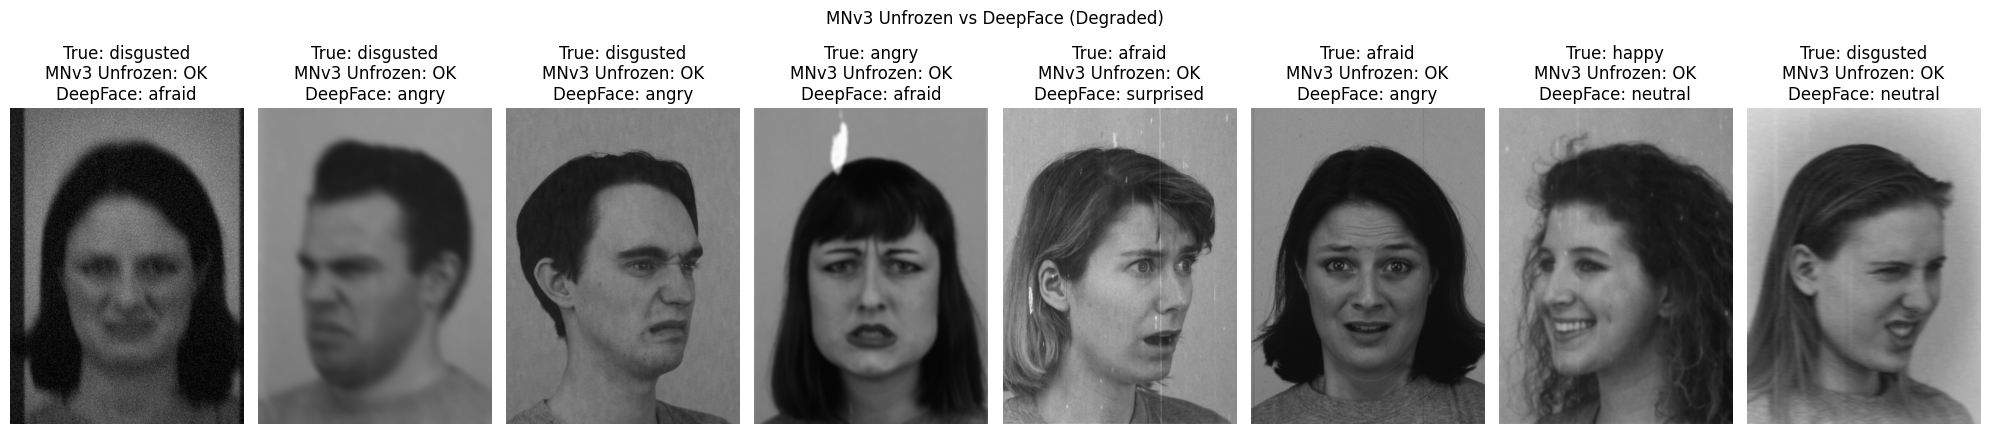

In [80]:
visualize_failures(res_df, "pred_unfrozen", "pred_deepface")

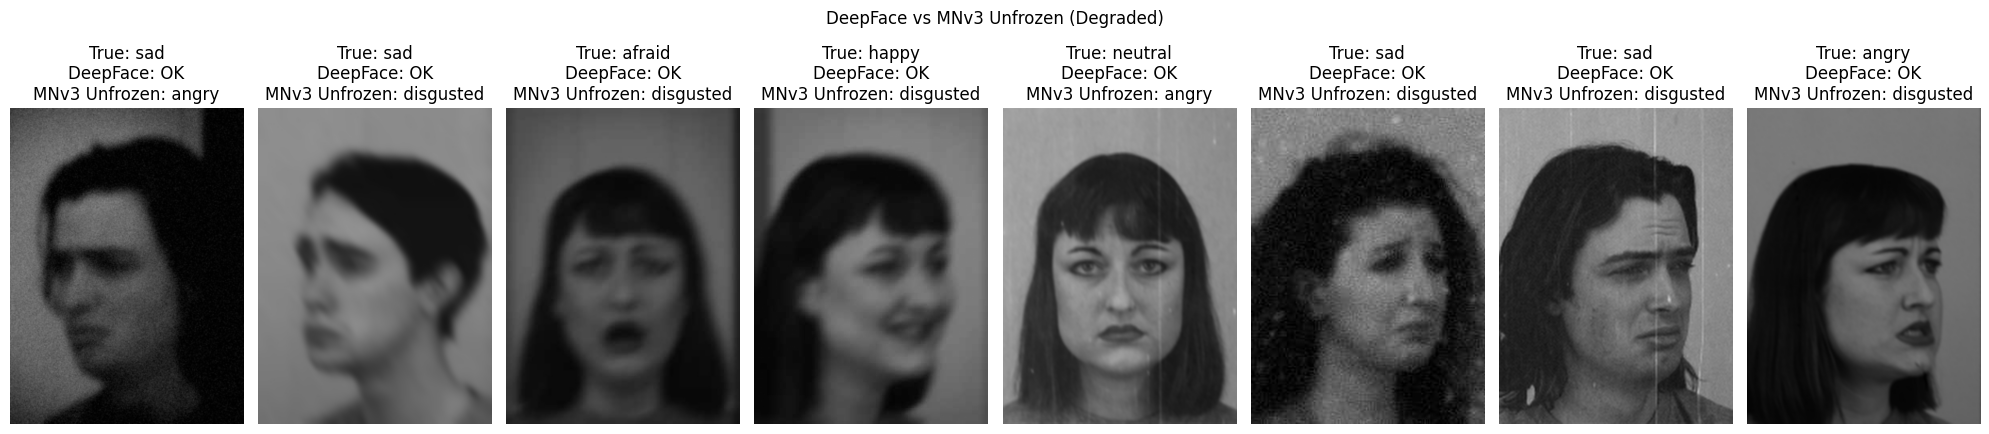

In [81]:
visualize_failures(res_df, "pred_deepface", "pred_unfrozen")

In [82]:
def get_gradcam(model, img_tensor, target_class_idx):
    gradients = []
    activations = []

    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])

    def forward_hook(module, input, output):
        activations.append(output)

    target_layer = model.model.features[-1]
    handle_f = target_layer.register_forward_hook(forward_hook)
    handle_b = target_layer.register_full_backward_hook(backward_hook)

    model.zero_grad()
    output = model(img_tensor)

    score = output[0, target_class_idx]
    score.backward()

    grads = gradients[0].cpu().data.numpy()[0]
    fmap = activations[0].cpu().data.numpy()[0]

    weights = np.mean(grads, axis=(1, 2))

    cam = np.zeros(fmap.shape[1:], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * fmap[i, :, :]

    cam = np.maximum(cam, 0)

    cam = cv2.resize(cam, (224, 224))
    cam = cam - np.min(cam)
    cam = cam / np.max(cam)

    handle_f.remove()
    handle_b.remove()

    return cam

In [83]:
def plot_gradcam_comparison(row, model, title):
    """Porównuje Oryginał vs Zdegradowany z nałożonym CAM"""

    paths = {
        "Original": Path("data/raw") / row["file"],
        "GrayScale": Path("data/grayscale") / row["file"],
        "Degraded": Path("data/degraded") / row["file"],
    }

    plt.figure(figsize=(15, 5))
    plt.suptitle(title)

    for i, (domain, p) in enumerate(paths.items()):
        img_pil = Image.open(p).convert("RGB")
        img_tensor = (
            VAL_TRANSFORM(img_pil)
            .unsqueeze(0)  # type: ignore
            .to("cuda" if torch.cuda.is_available() else "cpu")
        )
        img_tensor.requires_grad = True

        output = model(img_tensor)
        pred_idx = output.argmax(dim=1).item()

        heatmap = get_gradcam(model, img_tensor, pred_idx)

        img_np = np.array(img_pil.resize((224, 224))) / 255.0
        heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)  # type: ignore
        heatmap_colored = np.float32(heatmap_colored) / 255.0
        heatmap_colored = heatmap_colored[..., ::-1]  # type: ignore

        overlay = 0.5 * img_np + 0.5 * heatmap_colored

        plt.subplot(1, 3, i + 1)
        plt.imshow(overlay)
        plt.title(
            f"{domain}\nPred: {IDX_TO_EMOTION[pred_idx]} (True: {IDX_TO_EMOTION[row['true_idx']]})"
        )
        plt.axis("off")

    plt.show()

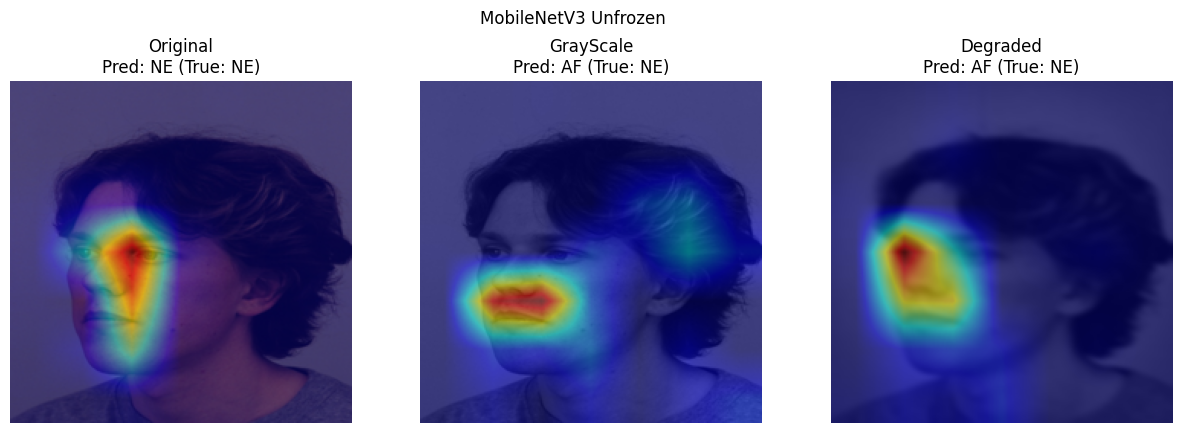

In [84]:
plot_gradcam_comparison(res_df.iloc[138], model_unfrozen, "MobileNetV3 Unfrozen")

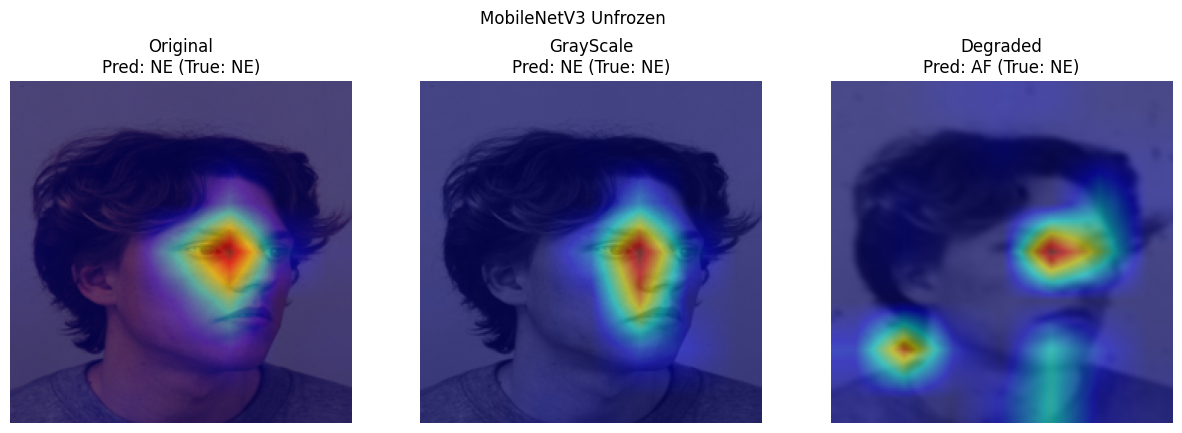

In [85]:
plot_gradcam_comparison(res_df.iloc[139], model_unfrozen, "MobileNetV3 Unfrozen")

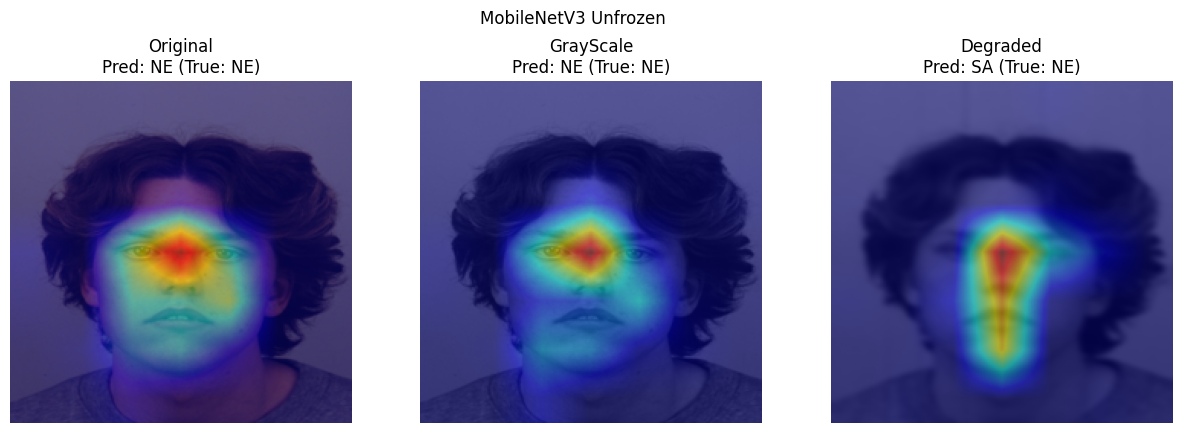

In [86]:
plot_gradcam_comparison(res_df.iloc[140], model_unfrozen, "MobileNetV3 Unfrozen")

In [87]:
def plot_confidence_bars(row, model):
    domains = ["Original", "Grayscale", "Degraded"]
    paths = [
        Path("data/raw") / row["file"],
        Path("data/grayscale") / row["file"],
        Path("data/degraded") / row["file"],
    ]

    plt.figure(figsize=(15, 4))

    for i, (domain, p) in enumerate(zip(domains, paths)):
        img = Image.open(p).convert("RGB")
        t = VAL_TRANSFORM(img).unsqueeze(0).to("cuda")  # type: ignore

        with torch.no_grad():
            logits = model(t)
            probs = F.softmax(logits, dim=1).cpu().numpy()[0]

        plt.subplot(1, 3, i + 1)
        colors = ["green" if idx == row["true_idx"] else "gray" for idx in range(7)]

        sns.barplot(
            x=list(EMOTION_MAP.keys()),
            y=probs,
            palette=colors,
            hue=list(EMOTION_MAP.keys()),
        )
        plt.ylim(0, 1.0)
        plt.title(f"{domain} (True: {IDX_TO_EMOTION[row['true_idx']]})")

    plt.suptitle(f"Rozkład pewności modelu dla pliku: {row['file']}")
    plt.show()

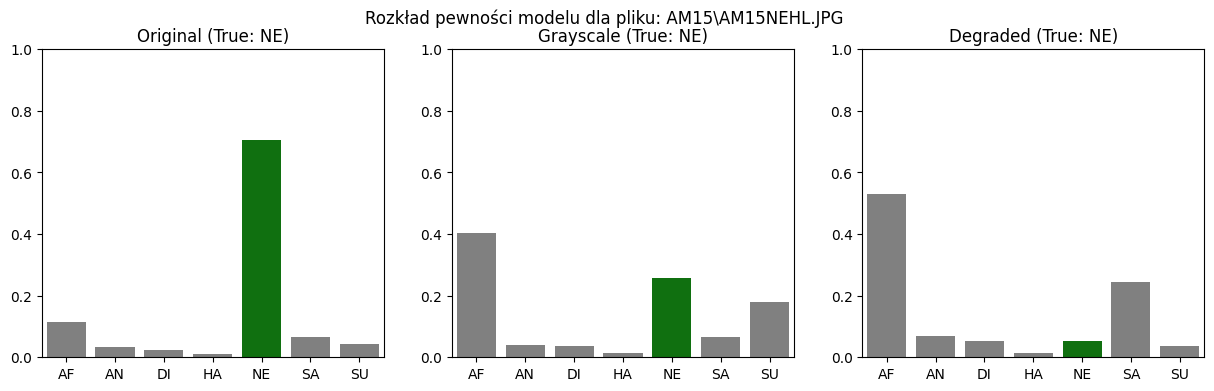

In [88]:
plot_confidence_bars(res_df.iloc[138], model_unfrozen)

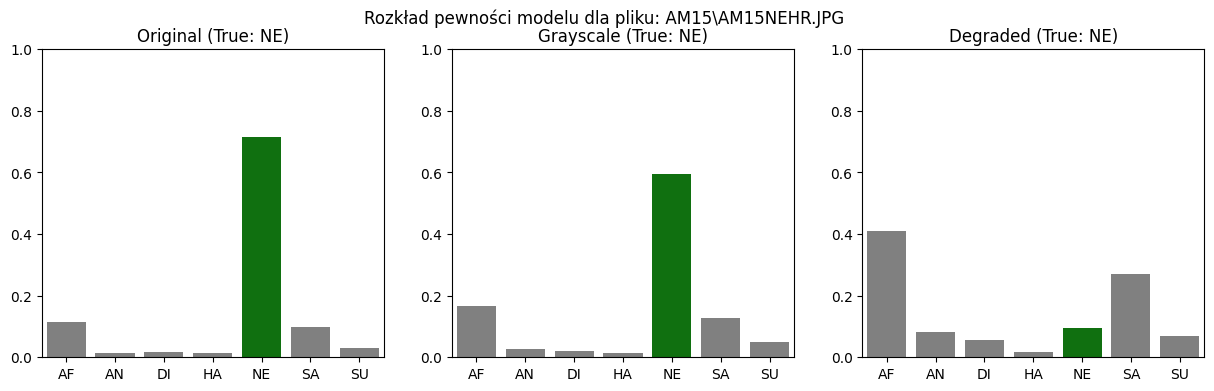

In [89]:
plot_confidence_bars(res_df.iloc[139], model_unfrozen)

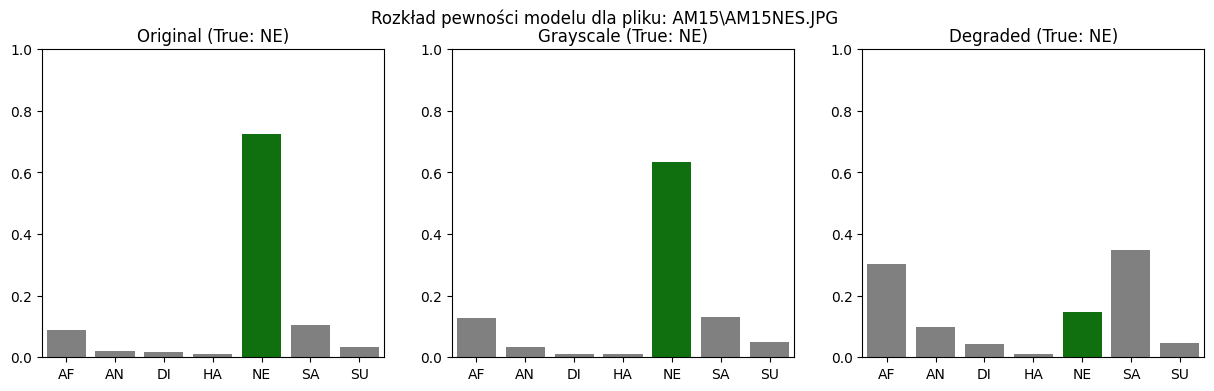

In [90]:
plot_confidence_bars(res_df.iloc[140], model_unfrozen)